In [1]:
# ============================
# Imports & Setup
# ============================
import os
import json
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image, ImageChops
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import re

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============================
# Config
# ============================
BATCH_SIZE = 64
EPOCHS = 15
LR = 2e-5
IMG_SIZE = 224
MAX_LEN = 256
PATIENCE = 3

train_img_path = '/kaggle/input/2025-sum-dpl-302-m/devset_images/devset_images'
train_json_path = '/kaggle/input/2025-sum-dpl-302-m/devset_images_metadata.json'
train_label_path = '/kaggle/input/2025-sum-dpl-302-m/devset_images_gt.csv'
test_img_path = '/kaggle/input/2025-sum-dpl-302-m/testset_images/testset_images'
test_csv_path = '/kaggle/input/2025-sum-dpl-302-m/test.csv'
save_result_path = '/kaggle/working/vit_bert2_predictions.csv'
save_checkpoint_path = '/kaggle/working/checkpoint.pth'

# ============================
# Utility Functions
# ============================
def safe_str(val):
    return val if isinstance(val, str) else ""

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'\b(img_\d+|dscf\d+|[\w-]+\.jpg)\b', '', text)
    text = re.sub(r'\b\d{2,4}[-/]\d{1,2}[-/]\d{1,4}\b', '', text)
    text = re.sub(r'\b\w{5,}\d+\b', '', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def load_metadata(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return {
        str(item['image_id']): {
            'title': safe_str(item.get('title')),
            'description': safe_str(item.get('description')),
            'user_tags': " ".join(item.get('user_tags', [])) if isinstance(item.get('user_tags'), list) else ""
        } for item in data['images']
    }

def load_labels(csv_path):
    df = pd.read_csv(csv_path)
    return dict(zip(df['id'].astype(str), df['label']))

def compute_metrics_binary(preds, labels):
    preds = (preds > 0.5).astype(int)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds)
    }

def autocrop_white_border(image, threshold=245):
    gray = image.convert("L")
    bg = Image.new("L", image.size, 255)
    diff = ImageChops.difference(gray, bg)
    bbox = diff.getbbox()
    if bbox:
        return image.crop(bbox)
    return image

# ============================
# Dataset
# ============================
class FloodDataset(Dataset):
    def __init__(self, image_dir, metadata_dict, label_dict=None, tokenizer=None, transform=None):
        self.image_dir = Path(image_dir)
        self.metadata = metadata_dict
        self.labels = label_dict
        self.tokenizer = tokenizer
        self.transform = transform
        self.image_ids = [
            image_id for image_id in metadata_dict
            if any((self.image_dir / f"{image_id}{ext}").exists() for ext in [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".webp"])
        ]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = next((self.image_dir / f"{image_id}{ext}" for ext in [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".webp"] if (self.image_dir / f"{image_id}{ext}").exists()), None)
        image = Image.open(img_path).convert("RGB")
        image = autocrop_white_border(image)
        if self.transform:
            image = self.transform(image)

        text_data = self.metadata[image_id]
        text_combined = (
            "Title: " + clean_text(text_data.get("title", "")) +
            " [SEP] Desc: " + clean_text(text_data.get("description", "")) +
            " [SEP] Tags: " + clean_text(text_data.get("user_tags", ""))
        )
        encoding = self.tokenizer(text_combined, padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)

        if self.labels:
            label = torch.tensor(self.labels[image_id], dtype=torch.float32)
            return image, input_ids, attention_mask, label
        else:
            return image, input_ids, attention_mask, image_id

# ============================
# Model
# ============================
class MultiModalDeBERTaViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = AutoModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.text_model = AutoModel.from_pretrained("microsoft/deberta-v3-small")
        self.vit_fc = nn.Sequential(nn.Linear(768, 256), nn.ReLU(), nn.Dropout(0.3))
        self.text_fc = nn.Sequential(nn.Linear(768, 256), nn.ReLU(), nn.Dropout(0.3))
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, image, input_ids, attention_mask):
        img_feat = self.vit(pixel_values=image).last_hidden_state[:, 0, :]
        img_feat = self.vit_fc(img_feat)
        text_feat = self.text_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        text_feat = self.text_fc(text_feat)
        combined = torch.cat((img_feat, text_feat), dim=1)
        return self.classifier(combined)

# ============================
# Train & Eval
# ============================
def train_epoch(model, dataloader, optimizer, criterion, scaler, scheduler):
    model.train()
    total_loss = 0
    for images, input_ids, attention_mask, labels in dataloader:
        images, input_ids, attention_mask, labels = images.to(device), input_ids.to(device), attention_mask.to(device), labels.unsqueeze(1).to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion):
    model.eval()
    preds, targets, total_loss = [], [], 0
    with torch.no_grad():
        for images, input_ids, attention_mask, labels in dataloader:
            images, input_ids, attention_mask, labels = images.to(device), input_ids.to(device), attention_mask.to(device), labels.unsqueeze(1).to(device)
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            targets.extend(labels.cpu().numpy())
    metrics = compute_metrics_binary(np.array(preds).flatten(), np.array(targets).flatten())
    metrics['loss'] = total_loss / len(dataloader)
    return metrics

# ============================
# Main
# ============================
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-small")
transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

metadata = load_metadata(train_json_path)
labels = load_labels(train_label_path)
train_ids, val_ids = train_test_split(list(labels.keys()), test_size=0.1, random_state=42)
train_ds = FloodDataset(train_img_path, {k: metadata[k] for k in train_ids}, {k: labels[k] for k in train_ids}, tokenizer, transform)
val_ds = FloodDataset(train_img_path, {k: metadata[k] for k in val_ids}, {k: labels[k] for k in val_ids}, tokenizer, transform)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

model = MultiModalDeBERTaViT()
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LR,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS,
    pct_start=0.1,
    div_factor=25.0,
    final_div_factor=1e4,
    anneal_strategy='cos',
    verbose=True
)

criterion = nn.BCEWithLogitsLoss()
scaler = GradScaler()

best_f1, patience = 0, 0
for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, scaler, scheduler)
    val_metrics = evaluate(model, val_loader, criterion)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['loss']:.4f} | F1: {val_metrics['f1']:.4f}")

    if val_metrics['f1'] > best_f1:
        best_f1 = val_metrics['f1']
        patience = 0
        torch.save(model.state_dict(), save_checkpoint_path)
    else:
        patience += 1
        if patience >= PATIENCE:
            print("Early stopping.")
            break

# ============================
# Inference
# ============================
print("Inferencing on test set...")
model.load_state_dict(torch.load(save_checkpoint_path))
model.eval()

test_df = pd.read_csv(test_csv_path)
test_metadata = {
    str(row['image_id']): {
        'title': row['title'] if pd.notna(row['title']) else "",
        'description': row['description'] if pd.notna(row['description']) else "",
        'user_tags': row['user_tags'] if pd.notna(row['user_tags']) else ""
    } for _, row in test_df.iterrows()
}
test_ds = FloodDataset(test_img_path, test_metadata, tokenizer=tokenizer, transform=transform)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

results = []
with torch.no_grad():
    for images, input_ids, attention_mask, image_ids in test_loader:
        images, input_ids, attention_mask = images.to(device), input_ids.to(device), attention_mask.to(device)
        outputs = model(images, input_ids, attention_mask)
        preds = (torch.sigmoid(outputs).cpu().numpy() > 0.5).astype(int).flatten()
        results.extend(zip(image_ids, preds))

pd.DataFrame(results, columns=["id", "label"]).to_csv(save_result_path, index=False)
print("Saved test predictions to:", save_result_path)

Device: cuda


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

2025-08-05 07:58:49.828720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754380729.998551      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754380730.048298      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

/tmp/ipykernel_36/631841041.py:232: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 | Train Loss: 0.6746 | Val Loss: 0.6415 | F1: 0.0000
Epoch 2 | Train Loss: 0.3843 | Val Loss: 0.2387 | F1: 0.8571
Epoch 3 | Train Loss: 0.1888 | Val Loss: 0.1717 | F1: 0.9179
Epoch 4 | Train Loss: 0.1143 | Val Loss: 0.1458 | F1: 0.9319
Epoch 5 | Train Loss: 0.0772 | Val Loss: 0.1423 | F1: 0.9263
Epoch 6 | Train Loss: 0.0516 | Val Loss: 0.1473 | F1: 0.9312
Epoch 7 | Train Loss: 0.0354 | Val Loss: 0.1533 | F1: 0.9323
Epoch 8 | Train Loss: 0.0263 | Val Loss: 0.1515 | F1: 0.9421
Epoch 9 | Train Loss: 0.0176 | Val Loss: 0.1294 | F1: 0.9387
Epoch 10 | Train Loss: 0.0154 | Val Loss: 0.1614 | F1: 0.9305
Epoch 11 | Train Loss: 0.0136 | Val Loss: 0.1415 | F1: 0.9437
Epoch 12 | Train Loss: 0.0109 | Val Loss: 0.1712 | F1: 0.9312
Epoch 13 | Train Loss: 0.0113 | Val Loss: 0.1859 | F1: 0.9259
Epoch 14 | Train Loss: 0.0106 | Val Loss: 0.1621 | F1: 0.9390
Early stopping.
Inferencing on test set...
Saved test predictions to: /kaggle/working/vit_bert2_predictions.csv


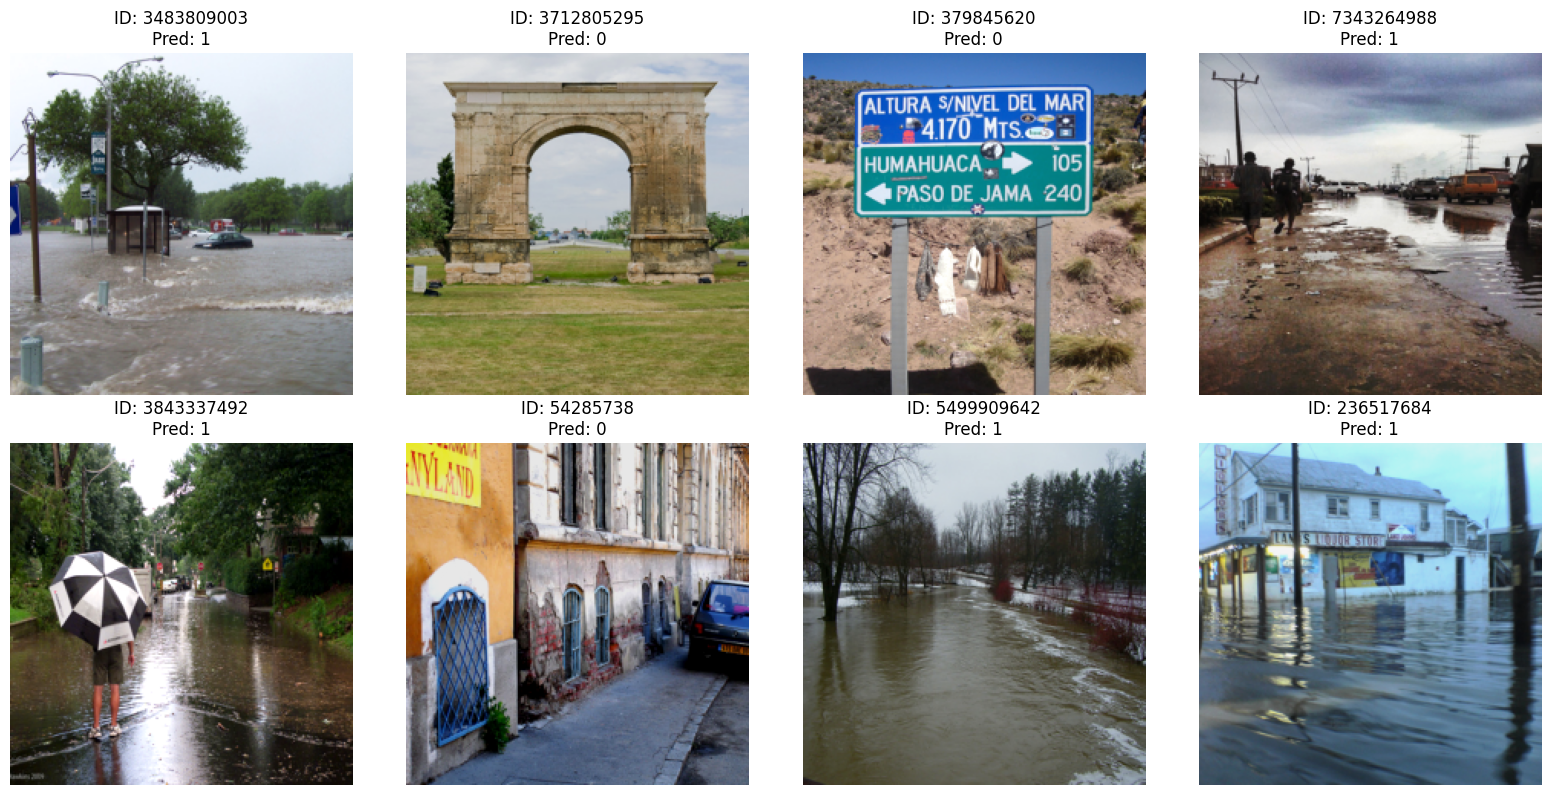

In [6]:
import matplotlib.pyplot as plt

def show_predictions(dataset, predictions, num_samples=8):
    plt.figure(figsize=(16, 8))
    for i in range(num_samples):
        image, _, _, image_id = dataset[i]
        label = predictions[i][1]
        plt.subplot(2, num_samples // 2, i + 1)
        img = image.permute(1, 2, 0).cpu().numpy() 
        img = (img * 0.5 + 0.5).clip(0, 1)  
        plt.imshow(img)
        plt.title(f"ID: {image_id}\nPred: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_predictions(test_ds, results, num_samples=8)
